In [1]:
#instalar librerias necesarias

!pip install pandas numpy matplotlib seaborn plotly scikit-learn tensorflow keras missingno seaborn openpyxl

In [34]:
# A continuacion se define un script que descarga el dataset, lo descomprime y lo mueve a la carpeta data/raw,
# junto con el diccionario de datos en formato csv.

# Se obtiene el dataset desde kaggle
!curl -L -o ./credit-risk-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/ranadeep/credit-risk-dataset

# se descomprime el archivo obtenido
!unzip -o ./credit-risk-dataset.zip -d ./credit-risk-dataset/

# se mueve el archivo a la carpeta data/raw
!mkdir -p data/raw
!mv ./credit-risk-dataset/loan/loan.csv data/raw/loan.csv

# se transforma el diccionario de datos a formato csv
!mv ./credit-risk-dataset/LCDataDictionary.xlsx data/raw/data_dictionary.xlsx

import pandas as pd
data_dictionary = pd.read_excel('data/raw/data_dictionary.xlsx', engine='openpyxl')
data_dictionary.to_csv('data/raw/data_dictionary.csv', index=False)

# se remueven los archivos temporales
!rm -rf ./credit-risk-dataset*
!rm -rf ./data/raw/data_dictionary.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  101M  100  101M    0     0  80.7M      0  0:00:01  0:00:01 --:--:-- 80.7M
Archive:  ./credit-risk-dataset.zip
  inflating: ./credit-risk-dataset/LCDataDictionary.xlsx  
  inflating: ./credit-risk-dataset/loan/loan.csv  


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [1]:
# inicialmente se realiza una exploracion sencilla de los datos,
# Se comienza con la variable target, que en este caso es la variable 'loan_status'
# y posteriormente se tratan las variables predictoras, discriminando entre variables numericas y categoricas.

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns


# Carga del dataset desde el archivo csv
df = pd.read_csv('data/raw/loan.csv')
df.head()

/tmp/ipykernel_104424/886851178.py:13: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Con el objetivo de conocer la naturaleza de la variable target, se realiza un conteo de los valores unicos de la variable 'loan_status'
loan_status = df['loan_status'].value_counts()
loan_status

loan_status
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

In [2]:
# Dado que se quiere obtener el riesgo de impago de una persona, se mapean los valores de la
# variable dependiente a binario, donde 1 representa que el prestamo fue pagado y 0 que no fue pagado.

# Diccionario para clasificar los estados en binario
status_map_binary = {
    "Current": 1,
    "Fully Paid": 1,
    "Issued": 1,
    "Does not meet the credit policy. Status:Fully Paid": 1,
    "Charged Off": 0,
    "Late (31-120 days)": 0,
    "Late (16-30 days)": 0,
    "In Grace Period": 0,
    "Default": 0,
    "Does not meet the credit policy. Status:Charged Off": 0
}

df['loan_status'] = df['loan_status'].map(status_map_binary)
df['loan_status'].value_counts()

loan_status
1    819950
0     67429
Name: count, dtype: int64

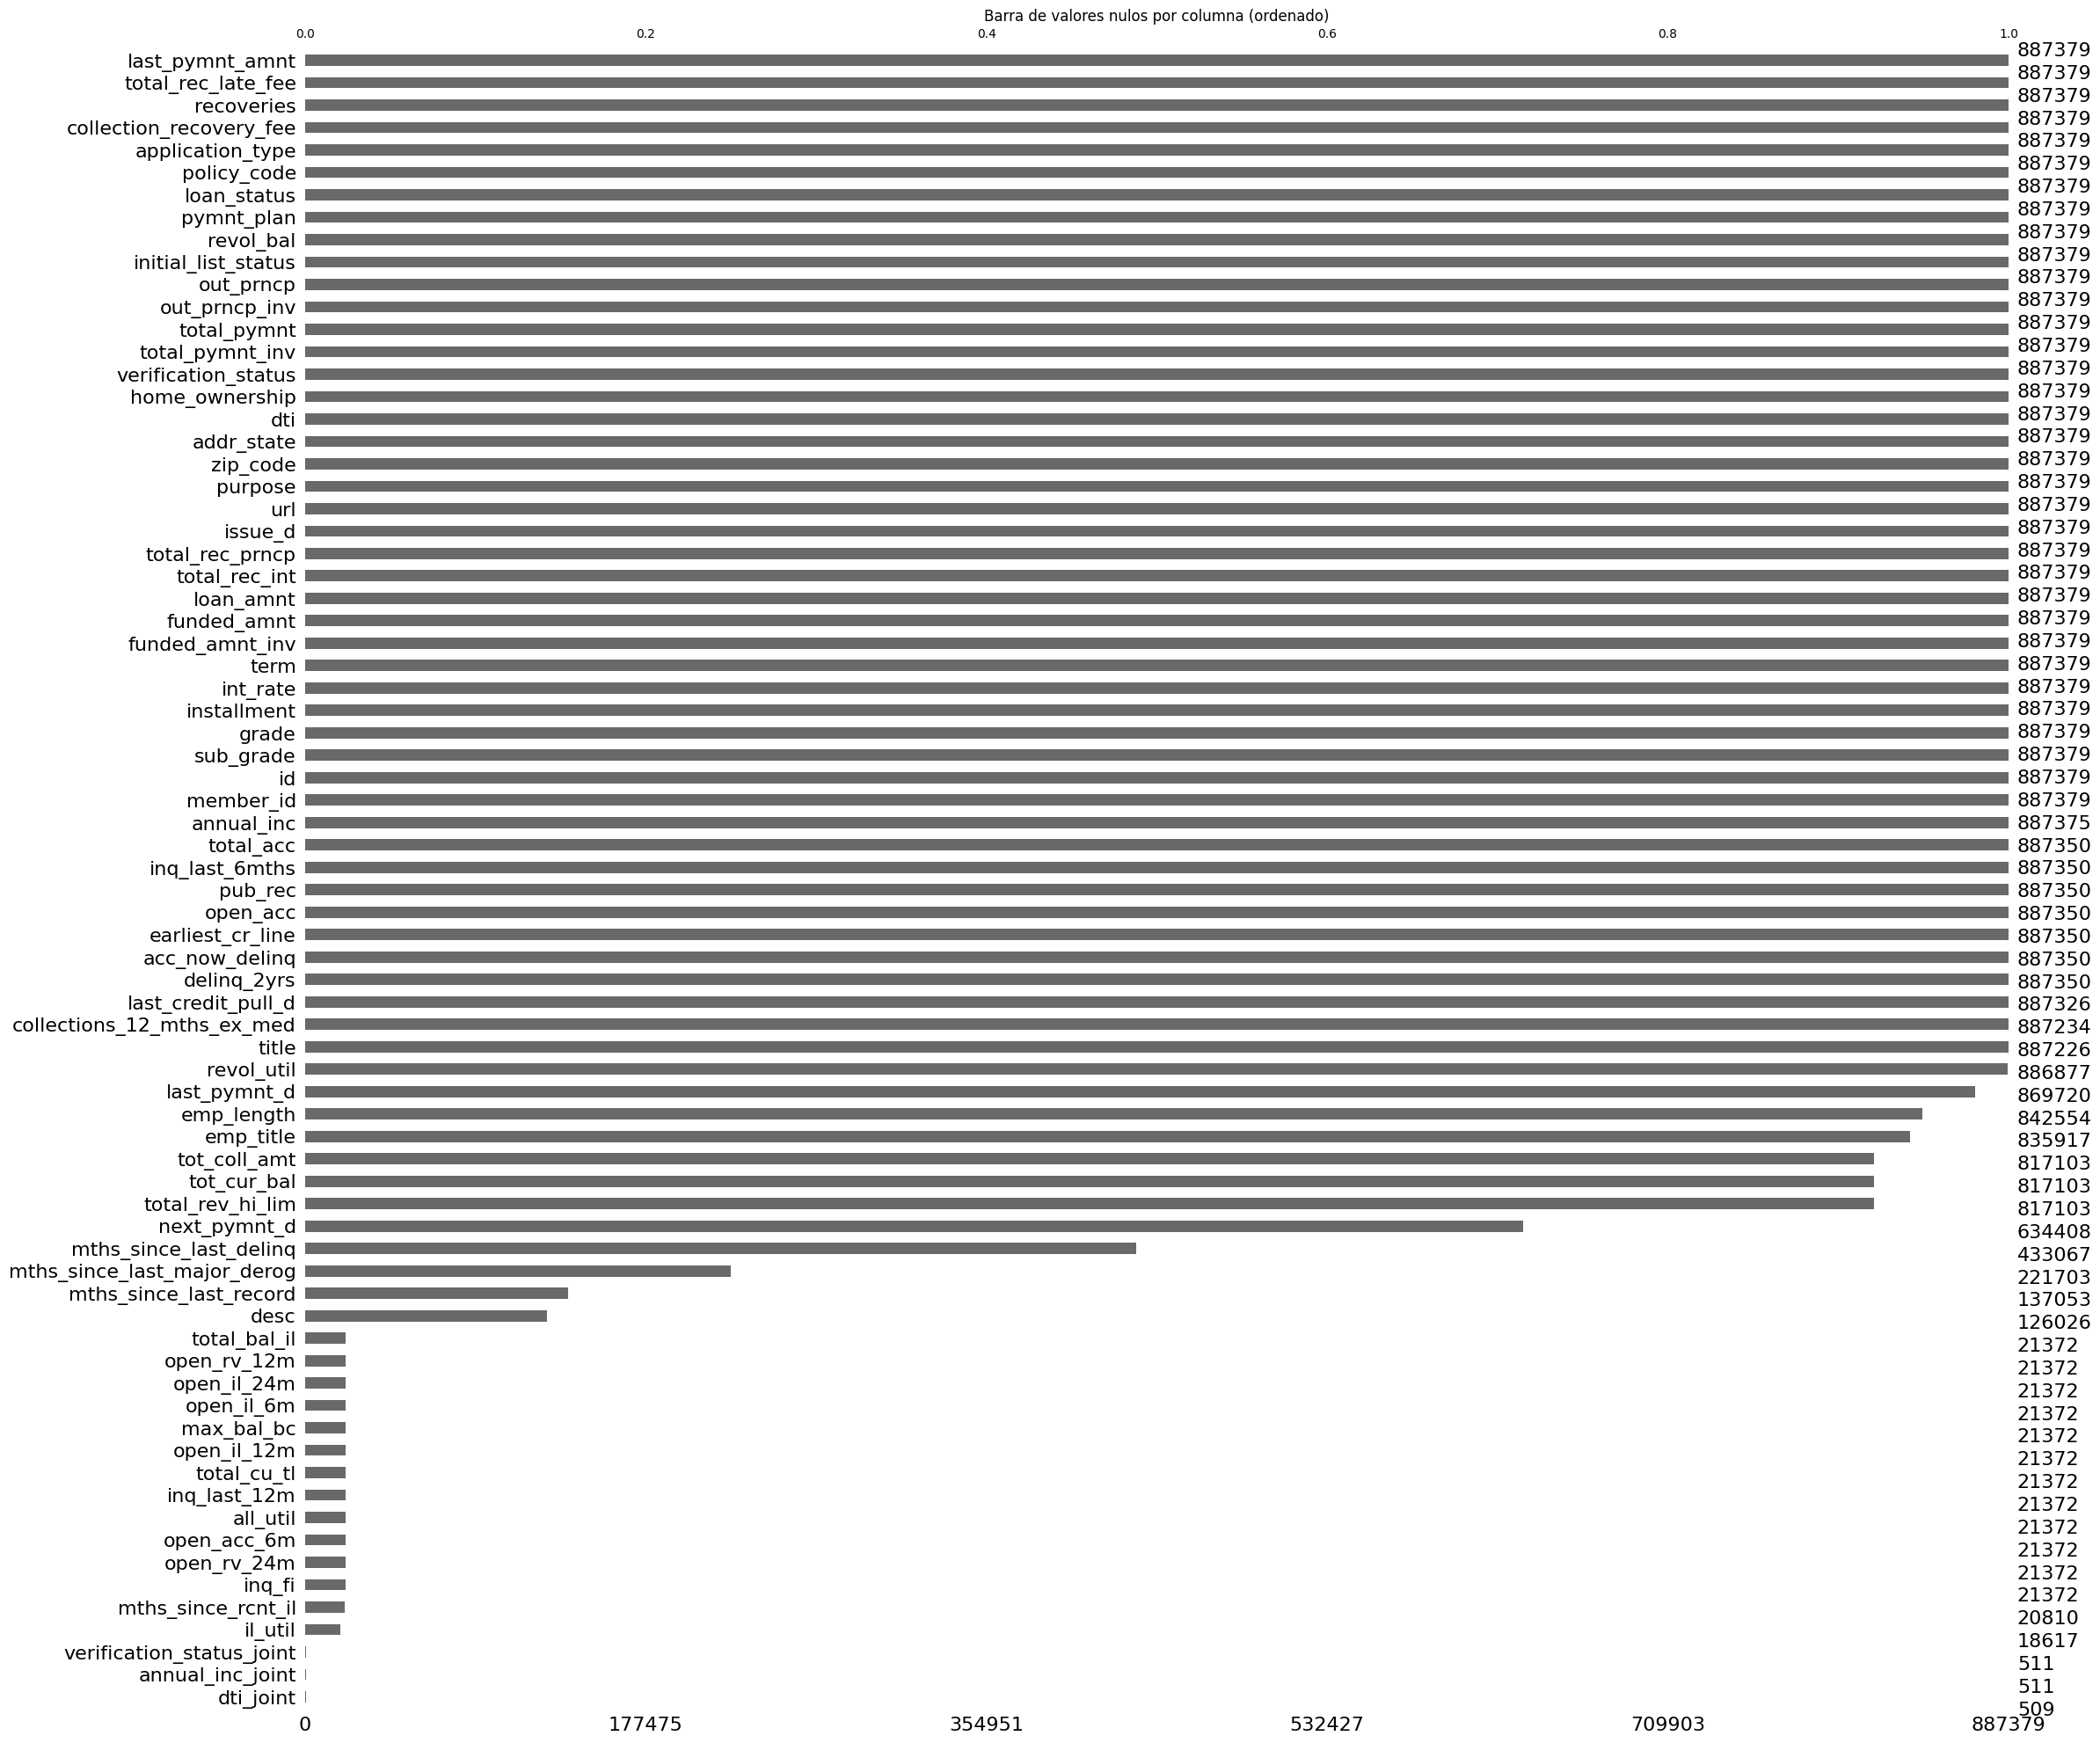

In [3]:
# Posteriormente, hacemos un analisis de nulidad de los datos, para identificar las variables que contienen valores nulos.
# y cómo se distribuyen estos valores en el dataset, usando la libreria missingno.

# Ordenar el DataFrame por la cantidad de valores nulos
df_sorted = df.loc[:, df.isnull().sum().sort_values(ascending=False).index]

# Visualización de nulidad ordenado por cantidad de nulos
msno.bar(df_sorted)
plt.title('Barra de valores nulos por columna (ordenado)')
plt.show()

In [4]:
#  Se evidencia que hay columnas con una cantidad considerable de valores nulos, por lo que
#  Se eliminan las columnas con mas de 70% de valores nulos
columns_to_drop_by_nullity = df.columns[df.isnull().mean() > 0.2].to_list()

df = df.drop(columns=columns_to_drop_by_nullity)

/tmp/ipykernel_104424/350581516.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_values_sorted['unique_values'], y=unique_values_sorted.index, palette='viridis')


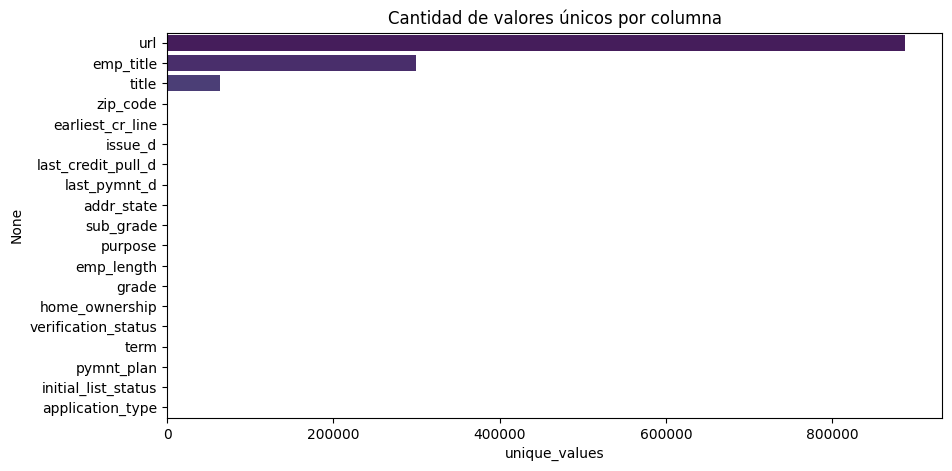

Columna con mas valores unicos: url, con 887379 valores unicos
Columna con menos valores unicos: term, con 2 valores unicos


In [5]:
# A continuación, se analizan las columnas categoricas, en este caso,
# por cantidad de valores únicos que poseen, con el objetivo de identificar las columnas que contienen demasiados valores únicos
# y que podrían no ser útiles para el modelo.

categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = pd.DataFrame(df[categorical_columns].nunique(), columns=['unique_values'])
unique_values_sorted = unique_values.sort_values(by='unique_values', ascending=False)

# Visualización de la cantidad de valores únicos con un diagrama de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=unique_values_sorted['unique_values'], y=unique_values_sorted.index, palette='viridis')
plt.title('Cantidad de valores únicos por columna')
plt.show()

# imprimir en texto la columna con mas valores unicos y la que menos
print(f'Columna con mas valores unicos: {unique_values_sorted.idxmax().values[0]}, con {unique_values_sorted.max().values[0]} valores unicos')
print(f'Columna con menos valores unicos: {unique_values_sorted.idxmin().values[0]}, con {unique_values_sorted.min().values[0]} valores unicos')

In [7]:
# Dado que se evidencia que existen columnas con con demasiados valores unicos, y algunas con solo un valor unico.
# se conservan entonces las columnas con menos de 10 valores unicos y mas de 1 valor unico

# Seleccionar las columnas con mas de 10 valores únicos
columns_to_drop_by_uniqueness = unique_values[(unique_values['unique_values'] > 10)].index.to_list()

columns_to_drop_by_uniqueness

['sub_grade',
 'emp_title',
 'emp_length',
 'issue_d',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'last_pymnt_d',
 'last_credit_pull_d']

In [8]:
# evidenciamos que la columna 'sub_grade' es una columna categorica que contiene 35 valores unicos, por lo que se deberia eliminar,
# sin embargo, esta puede obtener informacion relevante para el modelo, dado a que significa la calificacion de riesgo de un prestamo.
# asignado por una entidad financiera, por lo que se decide conservarla.

# Eliminar sub_grade de la lista de columnas a eliminar
columns_to_drop_by_uniqueness.remove('sub_grade')

# Eliminar las columnas seleccionadas
df = df.drop(columns=columns_to_drop_by_uniqueness)

/tmp/ipykernel_104424/272509039.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_values_sorted['unique_values'], y=unique_values_sorted.index, palette='viridis')


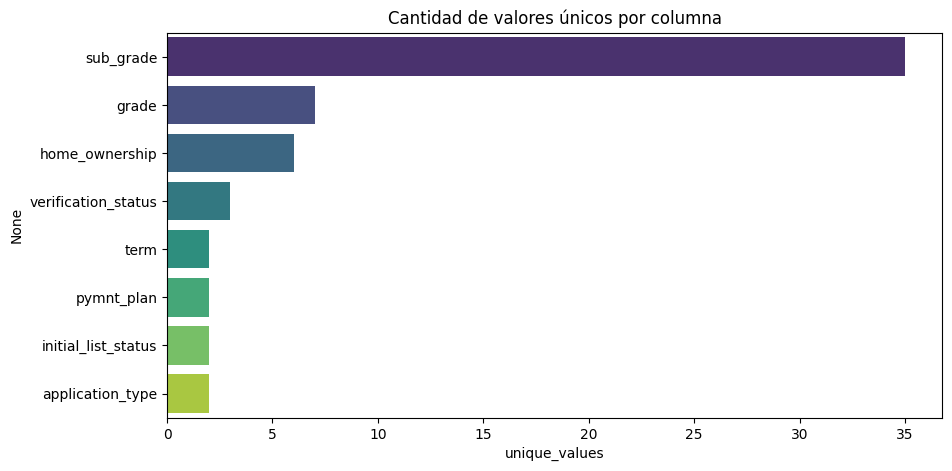

In [9]:
# posterior a esta remocion, se visualiza nuevamente la cantidad de valores unicos por columna

categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = pd.DataFrame(df[categorical_columns].nunique(), columns=['unique_values'])
unique_values_sorted = unique_values.sort_values(by='unique_values', ascending=False)

# Visualización de la cantidad de valores únicos con un diagrama de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=unique_values_sorted['unique_values'], y=unique_values_sorted.index, palette='viridis')
plt.title('Cantidad de valores únicos por columna')
plt.show()


In [10]:
# Debido a que la columna 'sub_grade' tiene un significado ordinal, se procede a codificarla
# de manera que el modelo pueda interpretarla de manera adecuada.

# Diccionarios para los valores segun la codificación
letter_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
number_map = {'1': 0.8, '2': 0.6, '3': 0.4, '4': 0.2, '5': 0.0}

# Función para codificar la columna 'subgrade'
def sub_grades_encoding(x):
    letter, number = x[0], x[1]
    return letter_map[letter] + number_map[number]

# codificacion de la columna 'sub_grade'
df['sub_grade'] = df['sub_grade'].apply(sub_grades_encoding)

/tmp/ipykernel_104424/1175753410.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sub_grade', palette='viridis')


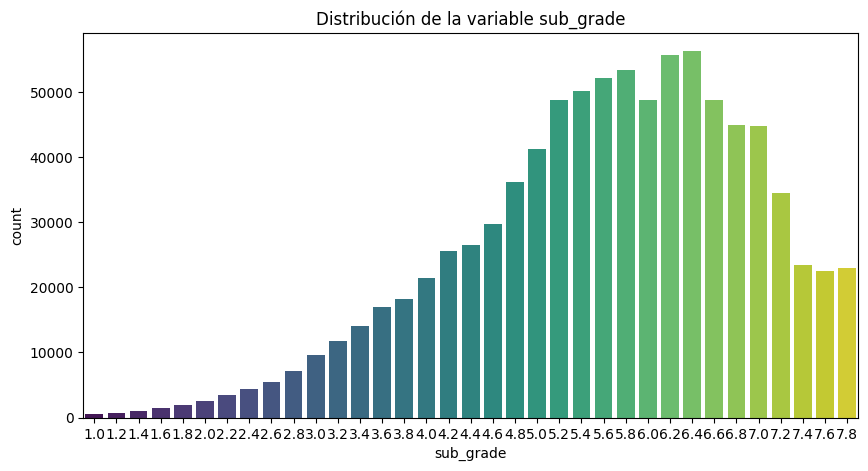

In [11]:
# diagrama de barras de la variable 'sub_grade' para visualizar la codificacion
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sub_grade', palette='viridis')
plt.title('Distribución de la variable sub_grade')
plt.show()


In [12]:
# posterior a esto, se puede eliminar la columna 'grade', dado que la columna 'sub_grade' ya contiene la misma informacion
df = df.drop(columns=['grade'])

In [13]:
# Se analizan los valores posibles de las columnas categoricas restantes
for column in df.select_dtypes(include=['object']).columns:
    print(f'{column}: {df[column].unique()}')

term: [' 36 months' ' 60 months']
home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
verification_status: ['Verified' 'Source Verified' 'Not Verified']
pymnt_plan: ['n' 'y']
initial_list_status: ['f' 'w']
application_type: ['INDIVIDUAL' 'JOINT']


In [14]:
# Debido a que existe una columna categorica ordinal en terminos de tiempo, se procede a codificarla
# y adicionalmente, se codifica si el status de la persona está verificado, ya que a pesar
# de tener tres valores posibles, dos de ellos significan lo mismo.

# codificar term en ordinal
term_map = {
    ' 36 months': 0,
    ' 60 months': 1
}
df['term'] = df['term'].map(term_map)

# codificar si el status de la persona está verificado
verification_status_map = {
    'Not Verified': 0,
    'Source Verified': 1,
    'Verified': 1
}
df['verification_status'] = df['verification_status'].map(verification_status_map)

/tmp/ipykernel_104424/3478950695.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_values_sorted['unique_values'], y=unique_values_sorted.index, palette='viridis')


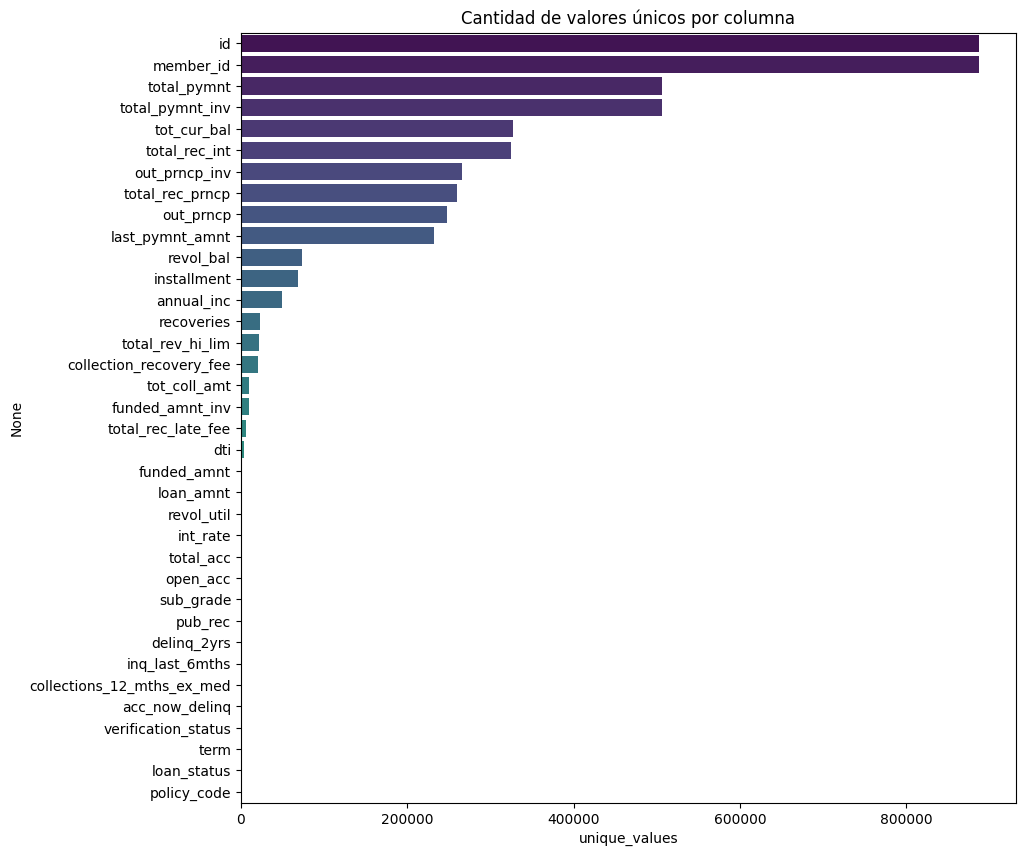

In [15]:
# Respecto a las columnas numericas, se buscan aquellas que tienen mas de 99% de valores distintos,
# y se eliminan de manera similar a las columnas categoricas.

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
unique_values = pd.DataFrame(df[numerical_columns].nunique(), columns=['unique_values'])
unique_values_sorted = unique_values.sort_values(by='unique_values', ascending=False)

# Visualización de la cantidad de valores únicos con un diagrama de barras
plt.figure(figsize=(10, 10))
sns.barplot(x=unique_values_sorted['unique_values'], y=unique_values_sorted.index, palette='viridis')
plt.title('Cantidad de valores únicos por columna')
plt.show()

In [16]:
# Se evidencian entre las columnas numericas, que existen algunas con
# una gran cantidad de valores unicos, lo cual tiene sentido, dentro del contexto para
# las variables continuas, pero a pesar de esto, otras, como 'id' y 'member_id' no aportan
# informacion relevante para el modelo, por lo que se eliminan.

df.drop(columns=['id', 'member_id'], inplace=True, errors='ignore')

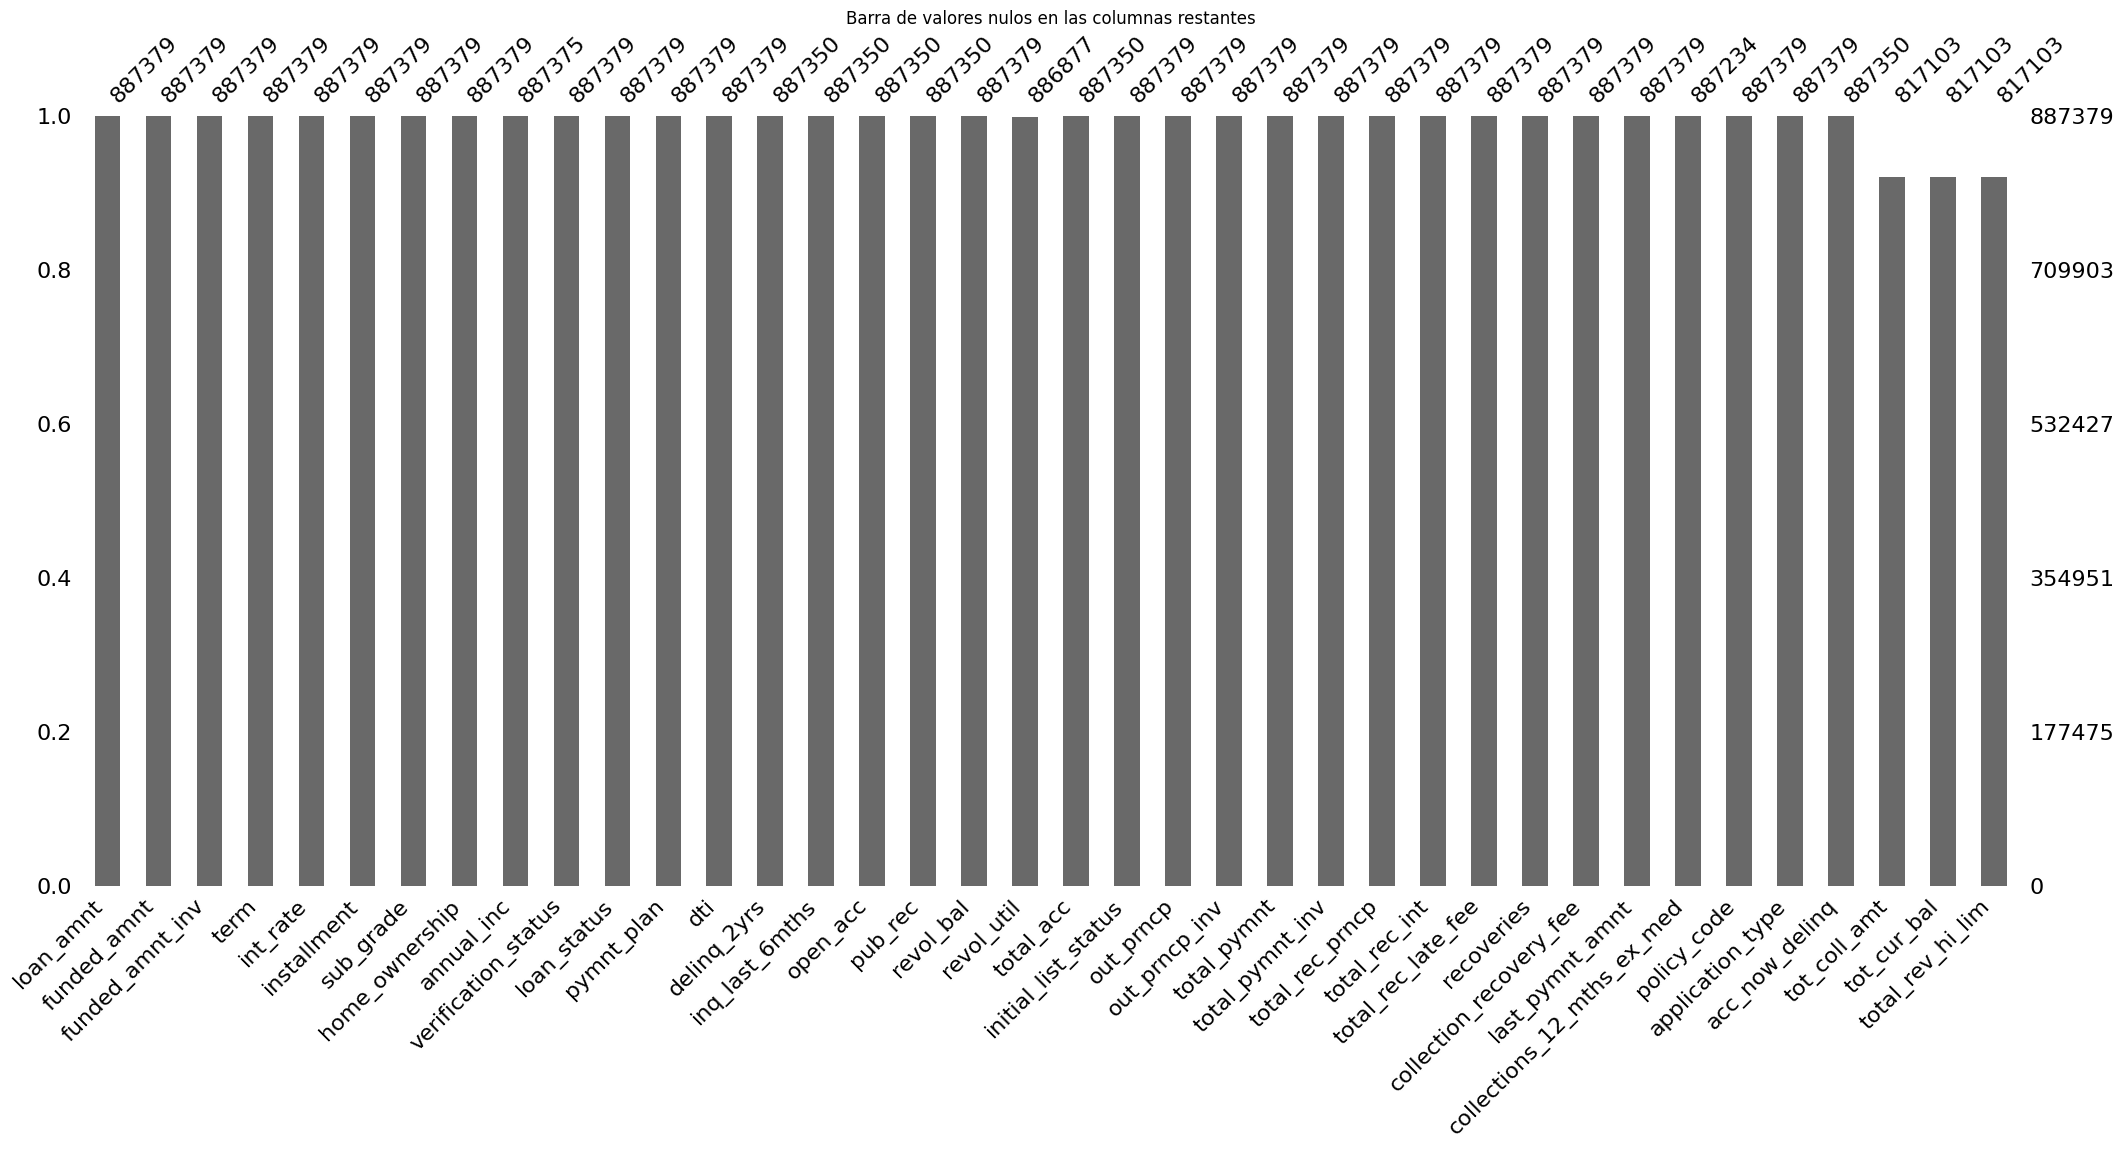

In [17]:
# finalmente, para el preprocesamiento de los datos, se visualiza la cantidad de valores nulos
# que quedan en el dataset.

# ver cantidad de valores nulos con missingno pero mostrando el porcentaje
msno.bar(df)
plt.title('Barra de valores nulos en las columnas restantes')
plt.show()

In [18]:
# se analiza la distribucion de las columnas con valores nulos en el dataset
columns_with_nulls = df.columns[df.isnull().any()]

# se analiza por medio de describe
df[columns_with_nulls].describe()

,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,8.873750e+05,887350.000000,887350.000000,887350.000000,887350.000000,886877.000000,887350.000000,887234.000000,887350.000000,8.171030e+05,8.171030e+05,8.171030e+05
mean,7.502759e+04,0.314442,0.694623,11.548469,0.195307,55.067693,25.268026,0.014380,0.004991,2.257026e+02,1.394582e+05,3.206862e+04
std,6.469830e+04,0.862244,0.998448,5.317313,0.582091,23.834344,11.840561,0.134191,0.077625,1.031137e+04,1.537500e+05,3.749826e+04
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.500000e+04,0.000000,0.000000,8.000000,0.000000,37.700000,17.000000,0.000000,0.000000,0.000000e+00,2.985300e+04,1.390000e+04
50%,6.500000e+04,0.000000,0.000000,11.000000,0.000000,56.000000,24.000000,0.000000,0.000000,0.000000e+00,8.055900e+04,2.370000e+04
75%,9.000000e+04,0.000000,1.000000,14.000000,0.000000,73.600000,32.000000,0.000000,0.000000,0.000000e+00,2.082050e+05,3.980000e+04
max,9.500000e+06,39.000000,33.000000,90.000000,86.000000,892.300000,169.000000,20.000000,14.000000,9.152545e+06,8.000078e+06,9.999999e+06


In [19]:
# Para no perder informacion relevante, se procede a imputar los valores nulos de las columnas numericas,
# con la mediana, ya que esta es menos sensible a los valores extremos.

from sklearn.impute import SimpleImputer

# Se separan las columnas numericas
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Se imputan los valores nulos con la mediana
imputer = SimpleImputer(strategy='median')

df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# se verifica que no existan valores nulos en el dataset
df.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
pymnt_plan                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_amnt               0
collecti

In [20]:
# Por último, se define el pipeline de preprocesamiento de los datos,
# donde se codifican las variables categoricas restantes con one hot encoding,
# y se normalizan las variables numericas.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import os



# Se separan las columnas categoricas y numericas
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop('loan_status')


# Se define el preprocesamiento de las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

In [21]:
# Sin embargo, evidenciamos que el dataset preprocesado tiene una gran cantidad de columnas,
# por lo que se procede a entrenar un modelo de Random Forest para obtener la importancia de las variables
# y seleccionar las mas importantes.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = df.drop(columns=['loan_status'])
y = df['loan_status']

# # Se ajusta el preprocessor a X
# preprocessor.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# Ahora se crea un pipeline v1 con el preprocesamiento y el modelo RandomForest

# Se define el pipeline
pipeline_v1 = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2025))
])

# Se entrena el modelo
pipeline_v1.fit(X_train, y_train)

# Se evalua el modelo
y_pred = pipeline_v1.predict(X_test)
print(classification_report(y_test, y_pred))

# Se obtiene la importancia de las variables
rf = pipeline_v1.named_steps['rf']
importances = rf.feature_importances_


KeyboardInterrupt: 

In [24]:
y.value_counts()

loan_status
1.0    819950
0.0     67429
Name: count, dtype: int64

/tmp/ipykernel_70257/2837828290.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette='viridis')


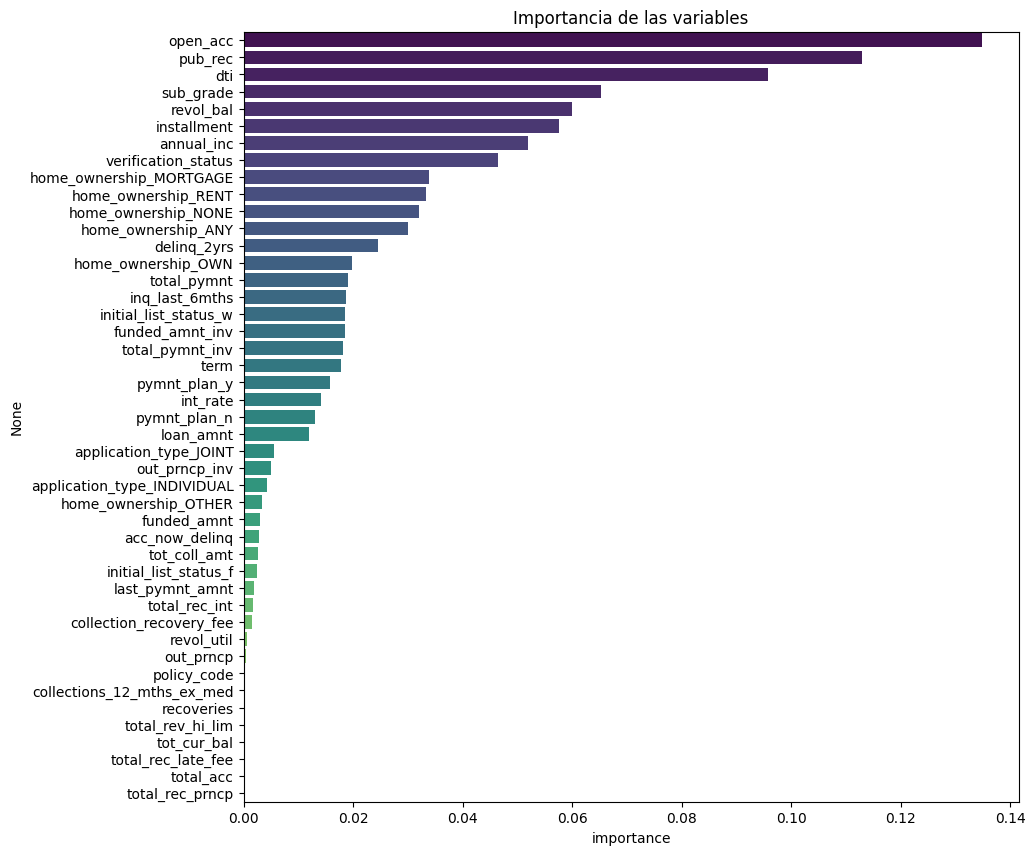

In [25]:
# Se transforma X_train y se obtienen sus columnas
X_train_categorical_columns = pipeline_v1.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
X_train_numerical_columns = pipeline_v1.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out(numerical_columns)
X_train_columns = list(X_train_categorical_columns) + list(X_train_numerical_columns)

# Se crea un dataframe con la importancia de las variables
feature_importances = pd.DataFrame(importances, index=X_train_columns, columns=['importance'])
feature_importances = pd.DataFrame(importances, index=X_train_columns, columns=['importance'])
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Se visualiza la importancia de las variables
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette='viridis')
plt.title('Importancia de las variables')
plt.show()

In [26]:
feature_importances.index.to_list()

['open_acc',
 'pub_rec',
 'dti',
 'sub_grade',
 'revol_bal',
 'installment',
 'annual_inc',
 'verification_status',
 'home_ownership_MORTGAGE',
 'home_ownership_RENT',
 'home_ownership_NONE',
 'home_ownership_ANY',
 'delinq_2yrs',
 'home_ownership_OWN',
 'total_pymnt',
 'inq_last_6mths',
 'initial_list_status_w',
 'funded_amnt_inv',
 'total_pymnt_inv',
 'term',
 'pymnt_plan_y',
 'int_rate',
 'pymnt_plan_n',
 'loan_amnt',
 'application_type_JOINT',
 'out_prncp_inv',
 'application_type_INDIVIDUAL',
 'home_ownership_OTHER',
 'funded_amnt',
 'acc_now_delinq',
 'tot_coll_amt',
 'initial_list_status_f',
 'last_pymnt_amnt',
 'total_rec_int',
 'collection_recovery_fee',
 'revol_util',
 'out_prncp',
 'policy_code',
 'collections_12_mths_ex_med',
 'recoveries',
 'total_rev_hi_lim',
 'tot_cur_bal',
 'total_rec_late_fee',
 'total_acc',
 'total_rec_prncp']

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir los datos en variables predictoras (X) y la variable objetivo (y)
X = df.drop(columns=['funded_amnt', 'acc_now_delinq', 'total_rec_int', 'loan_status','collection_recovery_fee',
       'revol_util', 'out_prncp', 'policy_code', 'collections_12_mths_ex_med',
       'recoveries', 'total_rev_hi_lim', 'tot_cur_bal', 'total_rec_late_fee',
       'total_acc', 'total_rec_prncp'])
y = df['loan_status'].astype(int)



In [60]:

numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [61]:

# # Dividir los datos en conjunto de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# # Se define el preprocesamiento de las columnas
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_columns),
#         ('cat', OneHotEncoder(), categorical_columns)
#     ]
# )

# # Ajustar el preprocesador a los datos de entrenamiento
# preprocessor.fit(X_train)
# X_train = preprocessor.transform(X_train)
# X_test = preprocessor.transform(X_test)

# # Definir la red neuronal
# model = Sequential([
#     Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Capa de entrada con 64 neuronas
#     Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
#     Dense(1, activation='sigmoid')  # Capa de salida (sigmoide para clasificación binaria)
# ])

# # Compilar el modelo
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])


# # Entrenar el modelo
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Evaluar el modelo
# y_pred = (model.predict(X_test) > 0.5).astype("int32")

# # Mostrar el reporte de clasificación
# print(classification_report(y_test, y_pred))

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# Se define el preprocesamiento de las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

# Aplicar el preprocesamiento a los datos
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)



2025-01-28 18:40:49.805438: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 18:40:49.961701: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 18:40:49.978061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738107650.004166  104424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738107650.010569  104424 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 18:40:50.069143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [23]:
X_test_preprocessed.shape

(177476, 45)

In [ ]:

# Construir el modelo de Keras
model = Sequential([
    Dense(64, input_dim=X_train_preprocessed.shape[1], activation='relu'),  # Capa de entrada con 64 neuronas
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
    Dense(1, activation='sigmoid')  # Capa de salida (sigmoide para clasificación binaria)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Entrenar el modelo
model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, verbose=1)

# Hacer predicciones
y_pred = (model.predict(X_test_preprocessed) > 0.5).astype("int32")

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib  # Para guardar el pipeline

# Crear una función para envolver el modelo de Keras
def create_keras_model(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
    return model

# Crear el modelo de Keras
keras_model = create_keras_model(input_dim=X_train_preprocessed.shape[1])

# Entrenar el modelo
keras_model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, verbose=1)

# Envolver el modelo de Keras en un transformador
class KerasModelWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=1)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

# Crear el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocesamiento
    ('keras_model', KerasModelWrapper(keras_model))  # Modelo Keras
])

# Ajustar el pipeline completo
pipeline.fit(X_train, y_train)

# Guardar el pipeline en un archivo
joblib.dump(pipeline, 'pipeline_keras_model.pkl')

print("Pipeline guardado exitosamente.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.9648 - loss: 0.1311 - recall: 0.9971
Epoch 2/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9726 - loss: 0.1100 - recall: 0.9993
Epoch 3/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9729 - loss: 0.1087 - recall: 0.9994
Epoch 4/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.9731 - loss: 0.1078 - recall: 0.9994
Epoch 5/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9731 - loss: 0.1073 - recall: 0.9994
Epoch 6/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9736 - loss: 0.1060 - recall: 0.9995
Epoch 7/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9732 - loss: 0.1070 - recall: 0.9995
Epoch 8/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9734 - loss: 0.1063 - recall: 0.9994
Epoch 9/10
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9734 - loss: 0.1060 - recall: 0.9995
Epoch 10/10
22185/22185 ━━━━

In [65]:
# download pipeline
from google.colab import files
files.download('pipeline_keras_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
# cargar el pipeline, y predecir y_test
pipeline = joblib.load('pipeline_keras_model.pkl')
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


5547/5547 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.65      0.79     13324
           1       0.97      1.00      0.99    164152

    accuracy                           0.97    177476
   macro avg       0.98      0.83      0.89    177476
weighted avg       0.97      0.97      0.97    177476



/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
